## Setup

In [1]:
import numpy as np
import pandas as pd

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set(style="darkgrid")

from nltk.translate.bleu_score import sentence_bleu

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5



This tutorial builds a few layers from scratch, use this variable if you want to switch between the custom and builtin implementations.

In [3]:
use_builtins = True

В этом руководстве используется множество низкоуровневых API, где легко ошибиться с формами. Этот класс используется для проверки форм на протяжении всего урока.

In [4]:
class ShapeChecker():
    def __init__(self):
    # Сохранение кэш всех видимых имен осей
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')
        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                             f"    found: {new_dim}\n"
                             f"    expected: {old_dim}\n")

# Загрузка данных

In [68]:
def load_data(path):
    with open(path, encoding='utf-8') as f:
        text = f.read()

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    source = [source for source, target in pairs]
    target = [target for source, target in pairs]

    return source, target

In [69]:
path = 'rus-eng-mini'
path_to_file = f'Date/{path}.txt'
source, target = load_data(path_to_file)

In [70]:
data = pd.DataFrame()
data['Source'] = source
data['Target'] = target

In [71]:
data.head()

,Source,Target
0,Марш!,Go.
1,Иди.,Go.
2,Идите.,Go.
3,Здравствуйте.,Hi.
4,Привет!,Hi.


In [72]:
data.tail()

,Source,Target
99995,Я этого не выношу.,I can't tolerate that.
99996,Я не могу дотронуться до пальцев ног.,I can't touch my toes.
99997,Я никому не могу верить.,I can't trust anybody.
99998,Я никому не могу доверять.,I can't trust anybody.
99999,Я пока не могу тебе доверять.,I can't trust you yet.


## Создайте набора данных

In [73]:
BUFFER_SIZE = len(source)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((source, target)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [74]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5].numpy())
    print()
    print(example_target_batch[:5].numpy())
    break

[b'\xd0\xa2\xd0\xbe\xd0\xbc \xd0\xb1\xd1\x8b\xd0\xbb \xd0\xba \xd1\x8d\xd1\x82\xd0\xbe\xd0\xbc\xd1\x83 \xd0\xb3\xd0\xbe\xd1\x82\xd0\xbe\xd0\xb2.'
 b'\xd0\xa2\xd0\xbe\xd0\xbc \xd1\x85\xd0\xbe\xd1\x87\xd0\xb5\xd1\x82, \xd1\x87\xd1\x82\xd0\xbe\xd0\xb1\xd1\x8b \xd1\x8f \xd0\xbe\xd1\x81\xd1\x82\xd0\xb0\xd0\xbb\xd0\xb0\xd1\x81\xd1\x8c.'
 b'\xd0\xaf \xd0\xb7\xd0\xbd\xd0\xb0\xd1\x8e \xd1\x82\xd0\xb2\xd0\xbe\xd0\xb9 \xd0\xb0\xd0\xb4\xd1\x80\xd0\xb5\xd1\x81.'
 b'\xd0\xad\xd1\x82\xd0\xbe \xd0\xb4\xd0\xbe\xd0\xb2\xd0\xbe\xd0\xbb\xd1\x8c\xd0\xbd\xd0\xbe \xd0\xbe\xd1\x87\xd0\xb5\xd0\xb2\xd0\xb8\xd0\xb4\xd0\xbd\xd0\xbe.'
 b'\xd0\xaf \xd0\xb4\xd0\xbe\xd0\xbb\xd0\xb6\xd0\xb5\xd0\xbd \xd0\xbf\xd0\xbe\xd0\xb9\xd1\x82\xd0\xb8.']

[b'Tom was ready for it.' b'Tom wants me to stay.' b'I know your address.'
 b"It's pretty obvious." b'I must go.']


## Предварительная обработка текста

Одна из целей этого руководства - создать модель, которую можно экспортировать как `tf.saved_model`. Чтобы сделать эту экспортированную модель полезной, она должна принимать входные данные `tf.string` и возвращать выходные данные `tf.string`: вся обработка текста происходит внутри модели.

### Стандартизация

Модель имеет дело с многоязычным текстом с ограниченным словарным запасом. Поэтому будет важно стандартизировать вводимый текст.

Первым шагом является нормализация Юникода для разделения символов с акцентом и замены символов совместимости их эквивалентами в формате ASCII.

Пакет `tensorflow_text` содержит операцию нормализации в юникоде:

In [75]:
example_text = tf.constant('Æз? Мæ ном хуыйны Алан.')

print(example_text.numpy().decode())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy().decode())

Æз? Мæ ном хуыйны Алан.
Æз? Мæ ном хуыйны Алан.


Unicode normalization will be the first step in the text standardization function:

In [76]:
def to_lower_case_eng(text):
    chars = tf.strings.unicode_decode(text, input_encoding='UTF-8')
    capital_mask = tf.logical_and(tf.greater_equal(chars, 65), tf.less(chars, 91))
    chars = chars + tf.cast(capital_mask, tf.int32) * 32
    return tf.strings.unicode_encode(chars, output_encoding='UTF-8')

In [77]:
def to_lower_case_rus(text):
    chars = tf.strings.unicode_decode(text, input_encoding='UTF-8')
    capital_mask = tf.logical_and(tf.greater_equal(chars, 1040), tf.less(chars, 1072))
    chars = chars + tf.cast(capital_mask, tf.int32) * 32
    return tf.strings.unicode_encode(chars, output_encoding='UTF-8')

In [78]:
def to_lower_case_oss(text):
    chars = tf.strings.unicode_decode(text, input_encoding='UTF-8')
    capital_mask = tf.logical_and(tf.greater_equal(chars, 198), tf.less(chars, 199))
    chars = chars + tf.cast(capital_mask, tf.int32) * 32
    return tf.strings.unicode_encode(chars, output_encoding='UTF-8')

In [79]:
def tf_lower_and_split_punct(text):
    # Замена символов 'æ' с кодом 1237 на символ 'æ' с кодом 230
    text = tf.strings.regex_replace(text, 'ӕ', 'æ')
    # Замена символа '—' на '-'
    text = tf.strings.regex_replace(text, '—', '-')
    
    text = tf_text.normalize_utf8(text, 'NFKD')
    
    # Нижний регистр
    text = to_lower_case_rus(text)
    text = to_lower_case_eng(text)
    text = to_lower_case_oss(text)
    
    # Удаление лишних символов, кроме списка представленных.
    text = tf.strings.regex_replace(text, '[^ a-zа-яæ.?!,-`…:;\']', '')
    # Добавьте пробелы вокруг знаков препинания.
    text = tf.strings.regex_replace(text, '[.?!,-`…:;\']', r' \0 ')
    # Удаление лишних пробелов.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [80]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Æз? Мæ ном хуыйны Алан.
[START] æз ?  мæ ном хуыины алан . [END]


### Векторизация текста

Эта функция стандартизации находится в `tf.keras.layers.TextVectorization`, который будет обрабатывать получение словаря и преобразование входного текста в последовательности токенов.

In [81]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

Слой `TextVectorization` и многие другие слои предварительной обработки имеют метод `adapt`. Этот метод считывает одну эпоху обучающих данных и работает очень похоже на `Model.fix`. Этот метод `adapt` инициализирует слой на основе данных. Здесь он определяет словарный запас:

In [82]:
input_text_processor.adapt(source)

# Первые 10 слов из входного словаря
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'я', '?', 'том', 'не', 'это']

In [83]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

# Первые 10 слов из выходного словаря
output_text_processor.adapt(target)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', "'", 'i', 'tom', 'you', '?']

Теперь эти слои могут преобразовывать пакет строк в пакет идентификаторов токенов:

In [84]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 9), dtype=int64, numpy=
array([[   2,    7,   23,  106,  329,  209,    4,    3,    0],
       [   2,    7,  145,   10,  100,    5, 3352,    4,    3],
       [   2,    5,   59,  105, 1222,    4,    3,    0,    0]],
      dtype=int64)>

Метод `get_vocabulary` можно использовать для преобразования идентификаторов токенов обратно в текст:

In [85]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] том был к этому готов . [END] '

Возвращаемые идентификаторы токенов заполняются нулем. Это можно легко превратить в маску:

Text(0.5, 1.0, 'Mask')

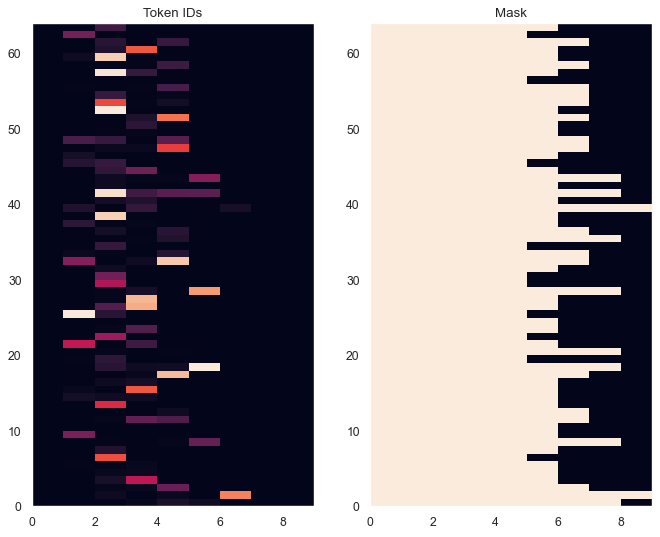

In [86]:
plt.figure(figsize=(10,8), dpi=80)
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

# Поссстроение модели

На следующей диаграмме показан обзор модели. На каждом временном шаге выходные данные декодера объединяются со взвешенной суммой по кодированному входному сигналу, чтобы предсказать следующее слово [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">


Прежде чем приступить к этому, определите несколько констант для модели:

In [87]:
embedding_dim = 256
units = 1024

## Encoder

Энкодер включает в себя:

1. Принимает список идентификаторов токенов (`input_text_processor`).
2. Ищет Embedding вектор для токенов (`layers.Embedding`).
3. Обробатывает Embedding в новую последовательность (`layers.GRU`).
4. Возвращает:
    * Обработанная последовательность. Это будет передано слою Attention.
    * Внутреннее состояние. Это будет использовано для инициализации декодера

In [88]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # Слой Embedding преобразует токены в векторы
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)

        # Слой GRU для обработки входных векторов
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       # Возвращает последовательность и состояние
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        # 2. Слой Embedding просматривается для каждого токена.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        # 3. GRU обрабатывает последовательность embedding'a.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        # 4. Возвращает новую последовательность и ее состояние.
        return output, state

In [89]:
# Преобразование входного текста в токены.
example_tokens = input_text_processor(example_input_batch)

# Закодирование входной последовательности
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 9)
Encoder output, shape (batch, s, units): (64, 9, 1024)
Encoder state, shape (batch, units): (64, 1024)


Энкодер возвращает свое внутреннее состояние, чтобы его состояние можно было использовать для инициализации декодера.

Также обычно RNN возвращает свое состояние, чтобы он мог обрабатывать последовательность по нескольким вызовам. Вы увидите больше об этом при создании декодера.

## Attention

Декодер использует внимание (Attention) для выборочного фокусирования на частях входной последовательности.
Attention принимает последовательность векторов в качестве входных данных для каждого примера и возвращает вектор "attention".

$$
\begin{eqnarray*}
    a_{ts} = \frac{exp(score(h_t, \overline h_s)}{\sum^{S}_{s'=1}exp(score(h_t, \overline h_{s'}))} & & \textrm{Attention weights} \\
    c_t = \sum_s a_{ts} \overline h_s & & \textrm{Context vector} \\
\end{eqnarray*}
$$

Где:

* $s$ - это индекс энкодера.
* $t$ - это индекс декодера.
* $\alpha_{ts}$ - это веса внимания.
* $h_s$ - это последовательность выходов энкодера, на которые обращено внимание
* $h_t$ - это состояние декодера, относящееся к последовательности
* $c_t$ - это является результирующим контекстным вектором.
* $a_t$ - это конечный результат, объединяющий "контекст" и "запрос".

Уравнения:

1. Вычисляет веса внимания, $\alpha_{ts}$, как softmax для выходной последовательности кодера.
2. Вычисляет вектор контекста как взвешенную сумму выходных данных кодера.


Последней является функция $score$. Ее задача состоит в том, чтобы вычислить scalar logit-score для каждой пары key-query.

В данной реализации используется [Адаптивное внимание Богданова](https://arxiv.org/pdf/1409.0473.pdf). TensorFlow включает в себя реализацию `layers.Attention` и `layers.AdditiveAttention`. Приведенный ниже класс обрабатывает весовые матрицы в паре `layers.Dense` слоев, и вызывает встроенную реализацию.

In [90]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))

        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores = True,
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

## Проверка слоя Attention

Создание слоя `BahdanauAttention`:

In [91]:
attention_layer = BahdanauAttention(units)

Этот слой принимает 3 входных параметра:

* The `query`: Это будет сгенерировано декодером позже.
* The `value`: Это будет выходной сигнал энкодера.
* The `mask`: Чтобы исключить заполнение, `example_tokens != 0`

In [92]:
(example_tokens != 0).shape

TensorShape([64, 9])

Векторизованная реализация attention позволяет передавать пакет последовательностей векторов запросов и пакет последовательностей векторов значений. В результате получается:

1. Пакет последовательностей результирующих векторов размером с запросы.
2. Пакет карт вниманий размером `(query_length, value_length)`.

In [93]:
# Позже декодер сгенерирует этот запрос внимания
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Обратите внимание на закодированные токены

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 9)


Веса внимания следует подводить к `1.0` для каждой последовательности.

Вот веса внимание всей последовательности при `t=0`:

Text(0.5, 1.0, 'Mask')

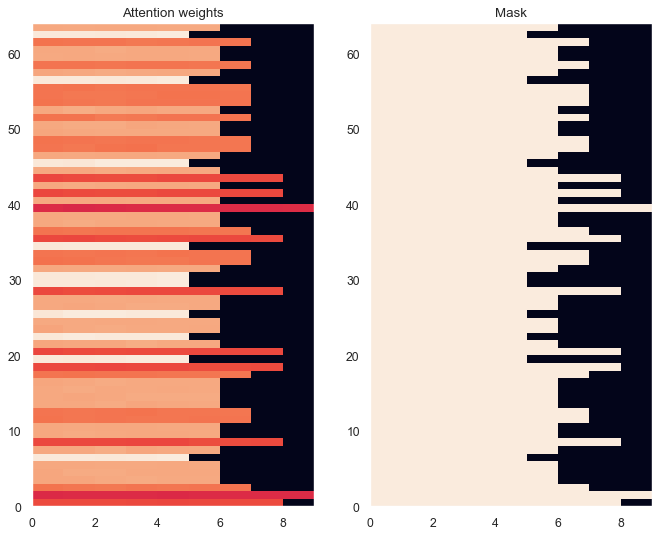

In [94]:
plt.figure(figsize=(10,8), dpi=80)
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

Из-за малой случайной инициализации веса внимание все близко к `1/(sequence_length)`. Если вы увеличиваете весы для одной последовательности, вы можете видеть, что есть некоторые _небольшие_ вариации, что модель может научиться расширять и эксплуатировать.

In [95]:
attention_weights.shape

TensorShape([64, 2, 9])

In [96]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 800x640 with 0 Axes>

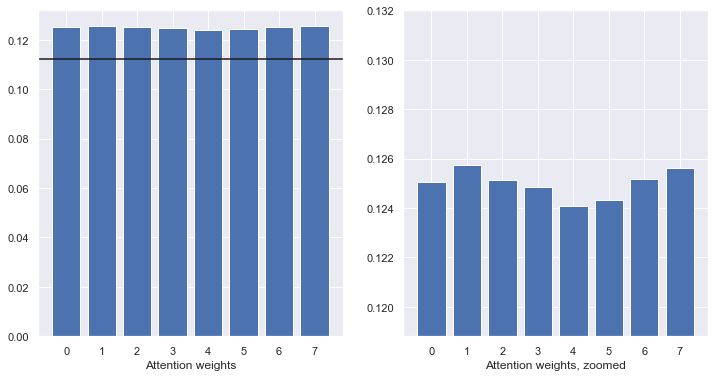

In [97]:
#@title
plt.figure(figsize=(10,8), dpi=80)
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

## Decoder

Задача декодера состоит в том, чтобы генерировать прогнозы для следующего выходного токена.

1. Декодер получает полный вывод энкодера.
2. Он использует RNN для отслеживания того, что было создано на данный момент.
3. Он использует свой выход RNN как запрос на внимание к выходным данным кодировщика, создавая вектор контекста.
4. Он объединяет выходные данные RNN и вектор контекста с использованием уравнения (ниже) для создания «вектора внимания».
5. Он генерирует логит-прогнозы для следующего токена на основе «вектора внимания».

$$
    a_t = f(c_t, h_t) = tanh(W_c[c_t; h_t])
$$

Вот Decoder класс и его инициализатор. Инициализатор создает все необходимые слои.

In [98]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer convets token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

`call` метод для этого слоя принимает и возвращает несколько тензоров. Организуем их в простые классы-контейнеры:

In [99]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

Here is the implementation of the `call` method:

In [100]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))

    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [101]:
Decoder.call = call

Энкодер обрабатывает свою полную последовательность ввода с одним вызовом его RNN. Эта реализация декодера может сделать это, а также для эффективного обучения. Но в этом руководстве декодер будет запускаться в цикле по нескольким причинам:

* Гибкость: написание цикла дает вам прямой контроль над процедурой обучения.
* Ясность: Это можно сделать маскирующие трюки и использовать `layers.RNN`, или `tfa.seq2seq`  API , чтобы упаковать все это в одном вызове. Но записать это в виде цикла может быть яснее.
* Петля бесплатное обучение демонстрируется в генерации текста tutiorial.


Теперь попробуйте использовать этот декодер.

In [102]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

The decoder takes 4 inputs.

* `new_tokens` -  последний маркер генерируется. Инициализировать декодер с  `"[START]"` токен.
* `enc_output` - Порожденный `Encoder`.
* `mask` - Логический тензор, указывающий, где `tokens != 0`
* `state` - Предыдущее состояние `state` вывода из декодера (внутреннее состояние RNN декодера).

In [103]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [104]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


Выполните выборку токена по логитам:

In [105]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Расшифруйте токен как первое слово вывода:

In [106]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['feet'],
       ['aren'],
       ['straws'],
       ['whole'],
       ['clean']], dtype='<U15')

Теперь используйте декодер для создания второго набора логитов.

- Передайте те же `enc_output` и `mask`, они не изменились.
- Передайте выбранный токен как `new_tokens`.
- Передайте `decoder_state`, который декодер вернул в прошлый раз, поэтому RNN продолжает с памятью о том, где он остановился в прошлый раз.


In [107]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [108]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['oddly'],
       ['private'],
       ['face'],
       ['crash'],
       ['cover']], dtype='<U15')

# Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

## Define the loss function

In [109]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

## Implement the training step

Start with a model class, the training process will be implemented as the `train_step` method on this model. See [Customizing fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

In [110]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                          embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks. 
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss. 
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

The `_preprocess` method, added below, implements steps #1 and #2: 

In [111]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask

In [112]:
TrainTranslator._preprocess = _preprocess

The `_train_step` method, added below, handles the remaining steps except for actually running the decoder: 

In [113]:
def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length-1):
          # Pass in two tokens from the target sequence:
          # 1. The current input to the decoder.
          # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                 enc_output, dec_state)
            loss = loss + step_loss

        # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [114]:
TrainTranslator._train_step = _train_step

The `_loop_step` method, added below, executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [115]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [116]:
TrainTranslator._loop_step = _loop_step

## Test the training step

Build a `TrainTranslator`, and configure it for training using the `Model.compile` method:

In [117]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Test out the `train_step`. For a text model like this the loss should start near:

In [118]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [119]:
%%time
for n in range(25):
    print(translator.train_step([example_input_batch, example_target_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3319235>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.28944>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.2052364>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.969909>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.2342386>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3753753>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8599606>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9874852>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5434425>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.450454>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3856905>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4070444>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4422612>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.425139>}
{'batch_loss': <tf.Tensor

While it's easier to debug without a `tf.function` it does give a performance boost. So now that the `_train_step` method is working, try the `tf.function`-wrapped `_tf_train_step`, to maximize performance while training:

In [120]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [121]:
TrainTranslator._tf_train_step = _tf_train_step

In [122]:
translator.use_tf_function = True

The first call will be slow, because it traces the function.

In [123]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.8203125>}

But after that it's usually 2-3x faster than the eager `train_step` method:

In [124]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.7843556>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.768187>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.7537527>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.7343483>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.7140572>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6802516>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6562002>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.628762>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6024153>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.5786767>}
Wall time: 2.33 s


A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

....................................................................................................

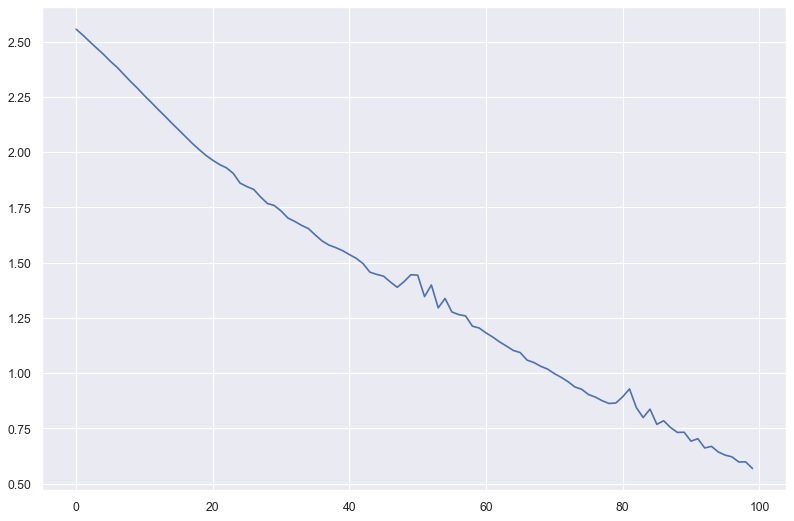

In [125]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())

plt.figure(figsize=(12,8), dpi=80)
plt.plot(losses)

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [133]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
    metrics=['accuracy']
)

## Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code. 

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [134]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [135]:
epochs=15

In [136]:
train_translator.fit(dataset, epochs=epochs, callbacks=[batch_loss])

Epoch 1/15
1356/1563 [=========================>....] - ETA: 49s - batch_loss: 1.6646

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,8), dpi=80)
plt.plot(batch_loss.logs)
plt.ylim([-1, 10])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

The visible jumps in the plot are at the epoch boundaries.

# Translate

Now that the model is trained, implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [67]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

In [68]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/4173397781.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


## Convert token IDs to text

The first method to implement is `tokens_to_text` which converts from token IDs to human readable text.

In [69]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))

    result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
    shape_checker(result_text, ('batch'))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

In [70]:
Translator.tokens_to_text = tokens_to_text

Input some random token IDs and see what it generates:

In [71]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'\xd0\xb1\xd0\xb0\xd1\x81\xd0\xb0\xd0\xb1\xd1\x8b\xd1\x80 \xd0\xb8\xd0\xb2\xd0\xb4\xd0\xb4\xd0\xb7\xd0\xb0\xd0\xb3',
       b'\xd1\x85\xd0\xbe\xd0\xbc \xd0\xba\xd0\xb0\xd0\xbc\xd0\xb5\xd1\x80\xc3\xa6',
       b'\xd0\xb7\xd1\x8b\xd0\xbd \xd1\x85\xd1\x83\xd1\x80\xd1\x8b',
       b'\xd0\xb1\xd0\xbe\xd0\xbd\xd1\x8b\xd1\x85\xd1\x8a\xc3\xa6\xd0\xb4 \xd0\xb1\xd0\xb0\xd0\xbc\xd0\xb1\xd0\xb0\xd1\x80\xd1\x8b\xd0\xbd',
       b'\xd1\x86\xc3\xa6\xd1\x83\xc3\xa6\xd0\xb3 \xc3\xa6\xd1\x80\xd1\x86\xd1\x83'],
      dtype=object)

## Sample from the decoder's predictions

This function takes the decoder's logit outputs and samples token IDs from that distribution:

In [72]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else: 
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature, num_samples=1)
        
    shape_checker(new_tokens, ('batch', 't'))

    return new_tokens

In [73]:
Translator.sample = sample

Test run this function on some random inputs:

In [74]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 866],
       [2440],
       [ 810],
       [1844],
       [1844]], dtype=int64)>

## Implement the translation loop

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using `tf.concat` to join them into tensors.

This implementation statically unrolls the graph out to `max_length` iterations.
This is okay with eager execution in python.

In [75]:
def translate_unrolled(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
        dec_input = DecoderInput(new_tokens=new_tokens,
                                 enc_output=enc_output,
                                 mask=(input_tokens!=0))

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        attention.append(dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens.append(new_tokens)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}


In [76]:
Translator.translate = translate_unrolled

Run it on a simple input:

In [77]:
%%time
input_text = tf.constant([
    'Как дела?', # "It's really cold here."
    'Доброе утро!', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

куыд дæ кæд цæмæн ?
ды уæ бон чи у !

Wall time: 253 ms


If you want to export this model you'll need to wrap this method in a `tf.function`. This basic implementation has a few issues if you try to do that:

1. The resulting graphs are very large and take a few seconds to build, save or load.
2. You can't break from a statically unrolled loop, so it will always run `max_length` iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.


In [78]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_translate = tf_translate

Run the `tf.function` once to compile it:

In [79]:
%%time
result = translator.tf_translate(input_text = input_text)

Wall time: 19.9 s


In [80]:
%%time
# result = translator.tf_translate(
#     input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

куыд дæ хъуыды кæны ?
уæ бон хорз !

Wall time: 1 ms


In [81]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
    shape_checker = ShapeChecker()
    shape_checker(input_text, ('batch',))

    batch_size = tf.shape(input_text)[0]

    # Encode the input
    input_tokens = self.input_text_processor(input_text)
    shape_checker(input_tokens, ('batch', 's'))

    enc_output, enc_state = self.encoder(input_tokens)
    shape_checker(enc_output, ('batch', 's', 'enc_units'))
    shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    shape_checker(new_tokens, ('batch', 't1'))

    # Initialize the accumulators
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    shape_checker(done, ('batch', 't1'))

    for t in tf.range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        attention = attention.write(t, dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)
        shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
        shape_checker(new_tokens, ('batch', 't1'))

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens = result_tokens.write(t, new_tokens)

        if tf.reduce_all(done):
            break

    # Convert the list of generated token ids to a list of strings.
    result_tokens = result_tokens.stack()
    shape_checker(result_tokens, ('t', 'batch', 't0'))
    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])
    shape_checker(result_tokens, ('batch', 't'))

    result_text = self.tokens_to_text(result_tokens)
    shape_checker(result_text, ('batch',))

    if return_attention:
        attention_stack = attention.stack()
        shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

        attention_stack = tf.squeeze(attention_stack, 2)
        shape_checker(attention_stack, ('t', 'batch', 's'))

        attention_stack = tf.transpose(attention_stack, [1, 0, 2])
        shape_checker(attention_stack, ('batch', 't', 's'))

        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [82]:
Translator.translate = translate_symbolic

The initial implementation used python lists to collect the outputs. This uses `tf.range` as the loop iterator, allowing `tf.autograph` to convert the loop. The biggest change in this implementation is the use of `tf.TensorArray` instead of python `list` to accumulate tensors. `tf.TensorArray` is required to collect a variable number of tensors in graph mode. 

With eager execution this implementation performs on par with the original:

In [83]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

цæмæ дæ бануазæм ?
уæ бон хорз !

Wall time: 243 ms


But when you wrap it in a `tf.function` you'll notice two differences.

In [84]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)

Translator.tf_translate = tf_translate

First: Graph creation is much faster (~10x), since it doesn't create `max_iterations` copies of the model.

In [85]:
%%time
result = translator.tf_translate(
    input_text = input_text)

Wall time: 3.34 s


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.

In [86]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

куыд дæ куыд дзырдта ? , кæцæи ?
тынг бон у !

Wall time: 155 ms


In [87]:
result['text']

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'\xd0\xba\xd1\x83\xd1\x8b\xd0\xb4 \xd0\xb4\xc3\xa6 \xd0\xba\xd1\x83\xd1\x8b\xd0\xb4 \xd0\xb4\xd0\xb7\xd1\x8b\xd1\x80\xd0\xb4\xd1\x82\xd0\xb0 ? , \xd0\xba\xc3\xa6\xd1\x86\xc3\xa6\xd0\xb8 ?',
       b'\xd1\x82\xd1\x8b\xd0\xbd\xd0\xb3 \xd0\xb1\xd0\xbe\xd0\xbd \xd1\x83 !'],
      dtype=object)>

## Visualize the process

The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [88]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[0.99999994 0.99999994 1.         0.9999999  1.         1.
 1.0000001  1.         1.        ]


Here is the attention distribution for the first output step of the first example. Note how the attention is now much more focused than it was for the untrained model:

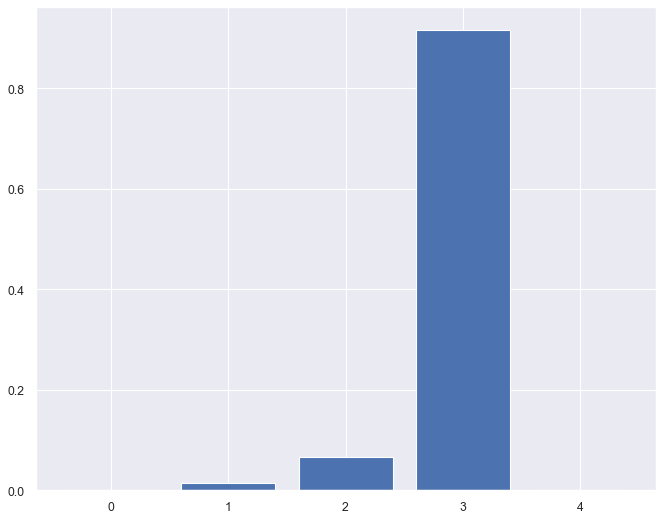

In [89]:
plt.figure(figsize=(10,8), dpi=80)
_ = plt.bar(range(len(a[0, :])), a[0, :])

Since there is some rough alignment between the input and output words, you expect the attention to be focused near the diagonal:

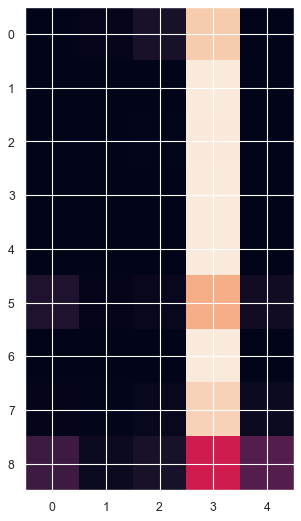

In [90]:
plt.figure(figsize=(10,8), dpi=80)
plt.imshow(np.array(a), vmin=0.0)

Here is some code to make a better attention plot:

In [91]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
    plt.figure(figsize=(10,8), dpi=80)
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

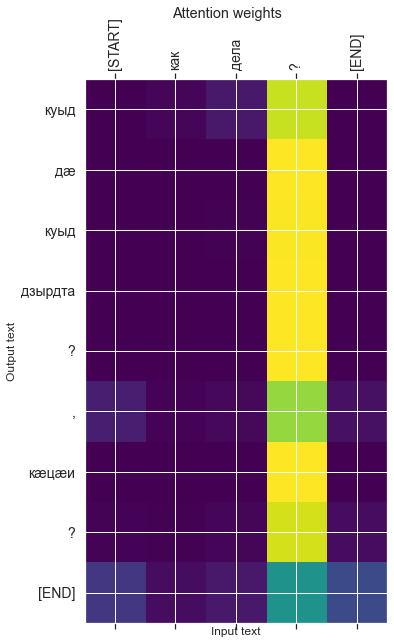

In [92]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

Translate a few more sentences and plot them:

In [93]:
%%time
three_input_text = tf.constant([
    'Как дела?',
    'Как дела?',
    'Ты дома?',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

уыры
куыд хъуыды кæныс ? ? æвзæрдæр дæхæдæг ?
фынæи ?

Wall time: 169 ms


In [94]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\xd1\x83\xd1\x8b\xd1\x80\xd1\x8b',
       b'\xd0\xba\xd1\x83\xd1\x8b\xd0\xb4 \xd1\x85\xd1\x8a\xd1\x83\xd1\x8b\xd0\xb4\xd1\x8b \xd0\xba\xc3\xa6\xd0\xbd\xd1\x8b\xd1\x81 ? ? \xc3\xa6\xd0\xb2\xd0\xb7\xc3\xa6\xd1\x80\xd0\xb4\xc3\xa6\xd1\x80 \xd0\xb4\xc3\xa6\xd1\x85\xc3\xa6\xd0\xb4\xc3\xa6\xd0\xb3 ?',
       b'\xd1\x84\xd1\x8b\xd0\xbd\xc3\xa6\xd0\xb8 ?'], dtype=object)>

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

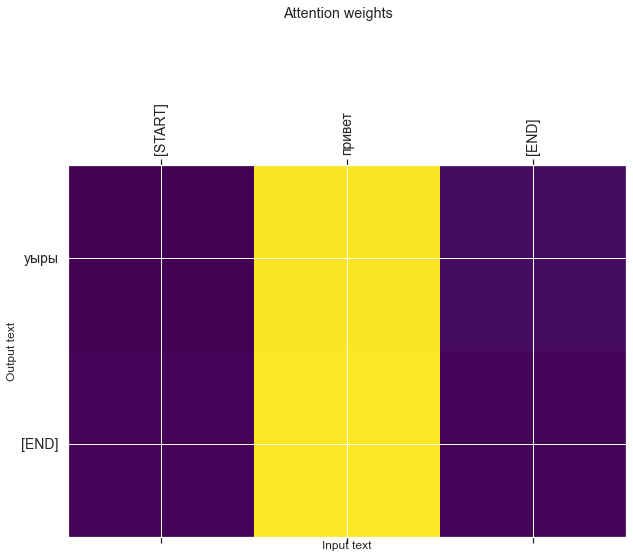

In [95]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

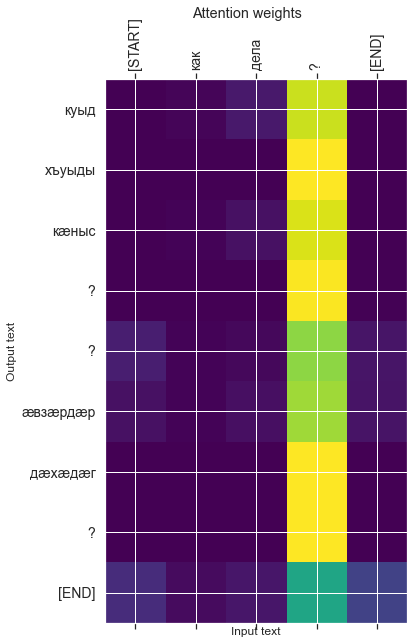

In [96]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

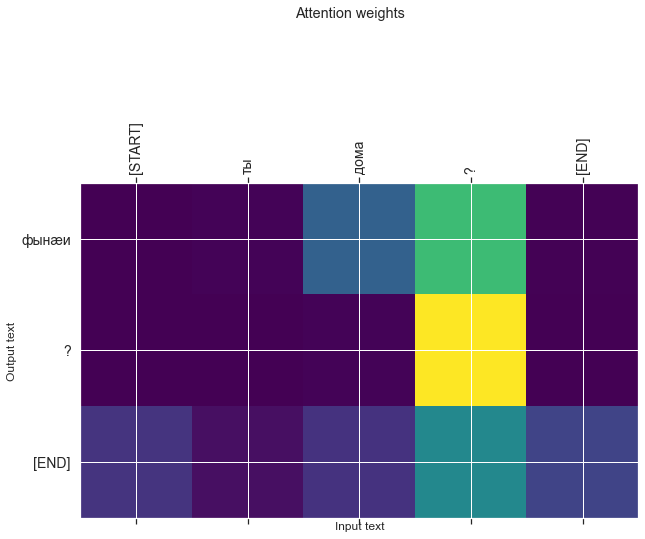

In [97]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. [Transformers](transformer.ipynb) solve this by using self-attention in the encoder and decoder.

In [98]:
long_input_text = tf.constant([source[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target[-1])))

Expected output:
 Фæуром!


C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\ONIGAT~1\AppData\Local\Temp/ipykernel_11120/2032440905.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 800x640 with 0 Axes>

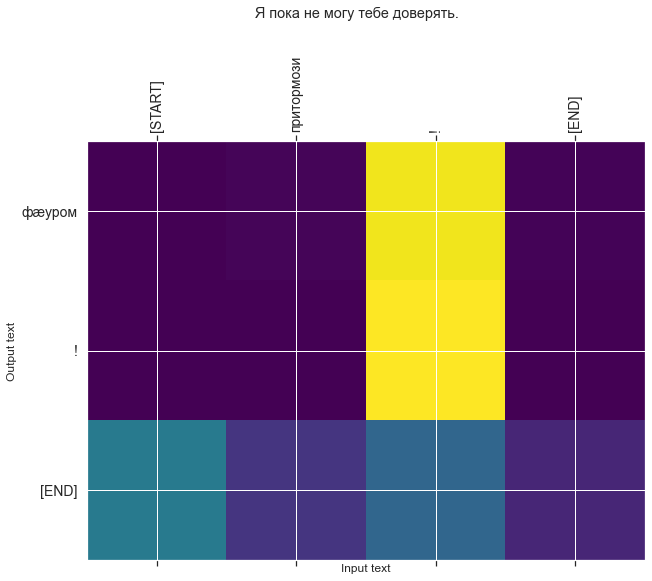

In [99]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('Я пока не могу тебе доверять.')

# Export

Once you have a model you're satisfied with you might want to export it as a `tf.saved_model` for use outside of this python program that created it.

Since the model is a subclass of `tf.Module` (through `keras.Model`), and all the functionality for export is compiled in a `tf.function` the model should export cleanly with `tf.saved_model.save`:  

Now that the function has been traced it can be exported using `saved_model.save`:

In [100]:
tf.saved_model.save(translator, f'GRU-[{units}]-Epochs[{epochs}]-EMD_DIM[{embedding_dim}]',
                    signatures={'serving_default': translator.tf_translate})

INFO:tensorflow:Assets written to: translator\assets


INFO:tensorflow:Assets written to: translator\assets


In [101]:
reloaded = tf.saved_model.load(f'GRU-[{units}]-Epochs[{epochs}]-EMD_DIM[{embedding_dim}])
result = reloaded.tf_translate(three_input_text)

In [102]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

акувæм
куыд дæ хъуыды кæныс ?
кæцы рбацыд иефсымæримæ рæстæг не хæринаг ?

Wall time: 99 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses a transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement wordpiece tokenization.
* Have a look at the [tensorflow_addons.seq2seq](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt) for implementing this sort of sequence to sequence model. The `tfa.seq2seq` package includes higher level functionality like `seq2seq.BeamSearchDecoder`. 